# Generative Adverserial Network on Digits Dataset

### Imports

In [1]:
import os
import numpy as np

from ztlearn.utils import *
from ztlearn.dl.models import Sequential
from ztlearn.optimizers import register_opt
from ztlearn.datasets.digits import fetch_digits
from ztlearn.dl.layers import BatchNormalization, Dense, Dropout, Activation

/home/jefkine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Preview samples from the Digits Dataset

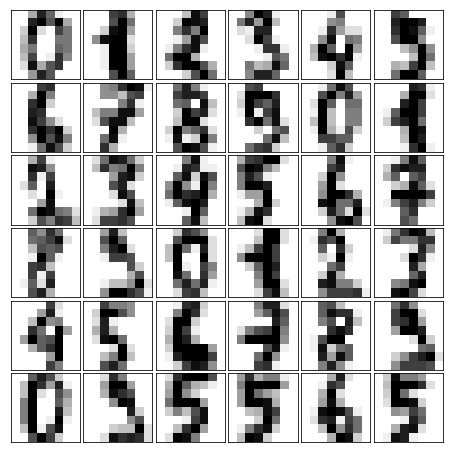

In [2]:
data = fetch_digits(custom_path = os.getcwd() + '/..')
plot_img_samples(data.data, None)

### Utils and Variables Setup

In [3]:
img_rows = 8
img_cols = 8
img_dim  = 64  # is the product (img_rows * img_cols)

latent_dim = 100
batch_size = 128
half_batch = int(batch_size * 0.5)

verbose   = False
init_type = 'he_uniform'

gen_epoch = 500
gen_noise = np.random.normal(0, 1, (36, latent_dim))  # 36 as batch size and is also the number of sample to be generated at the prediction stage

model_epochs = 7000
model_stats  = {'d_train_loss': [], 'd_train_acc': [], 'g_train_loss': [], 'g_train_acc': []}

d_opt = register_opt(optimizer_name = 'adam', beta1 = 0.5, learning_rate = 0.0001)
g_opt = register_opt(optimizer_name = 'adam', beta1 = 0.5, learning_rate = 0.00001)

### Generator Model

In [4]:
def stack_generator_layers(init):
    model = Sequential(init_method = init)
    model.add(Dense(128, input_shape = (latent_dim,)))
    model.add(Activation('leaky_relu'))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(256))
    model.add(Activation('leaky_relu'))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(512))
    model.add(Activation('leaky_relu'))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(img_dim, activation = 'tanh'))

    return model

### Discriminator Model

In [5]:
def stack_discriminator_layers(init):
    model = Sequential(init_method = init)
    model.add(Dense(256, input_shape = (img_dim,)))
    model.add(Activation('leaky_relu', alpha = 0.2))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('leaky_relu', alpha = 0.2))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation = 'sigmoid'))

    return model

### Combined Generator Discriminator Model

In [6]:
# stack and compile the generator
generator = stack_generator_layers(init = init_type)
generator.compile(loss = 'cce', optimizer = g_opt)

# stack and compile the discriminator
discriminator = stack_discriminator_layers(init = init_type)
discriminator.compile(loss = 'cce', optimizer = d_opt)

# stack and compile the generator_discriminator
generator_discriminator = Sequential(init_method = init_type)
generator_discriminator.layers.extend(generator.layers)
generator_discriminator.layers.extend(discriminator.layers)
generator_discriminator.compile(loss = 'cce', optimizer = g_opt)

generator.summary('digits generator')
discriminator.summary('digits discriminator')

generator_discriminator.summary('digits gan')
model_name = generator_discriminator.model_name

# rescale to range [-1, 1]
images = range_normalize(data.data.astype(np.float32))


 DIGITS GENERATOR

 Input Shape: (100,)
+------------------------+---------+--------------+
¦ LAYER TYPE             ¦  PARAMS ¦ OUTPUT SHAPE ¦ 
+------------------------+---------+--------------+
¦ Dense                  ¦  12,928 ¦       (128,) ¦ 
¦ Activation: LEAKY RELU ¦       0 ¦       (128,) ¦ 
¦ BatchNormalization     ¦     256 ¦       (128,) ¦ 
¦ Dense                  ¦  33,024 ¦       (256,) ¦ 
¦ Activation: LEAKY RELU ¦       0 ¦       (256,) ¦ 
¦ BatchNormalization     ¦     512 ¦       (256,) ¦ 
¦ Dense                  ¦ 131,584 ¦       (512,) ¦ 
¦ Activation: LEAKY RELU ¦       0 ¦       (512,) ¦ 
¦ BatchNormalization     ¦   1,024 ¦       (512,) ¦ 
¦ Dense                  ¦  32,832 ¦        (64,) ¦ 
+------------------------+---------+--------------+

 TOTAL PARAMETERS: 212,160


 DIGITS DISCRIMINATOR

 Input Shape: (64,)
+------------------------+--------+--------------+
¦ LAYER TYPE             ¦ PARAMS ¦ OUTPUT SHAPE ¦ 
+------------------------+--------+---------

### Model Training and Outputs

Computing: [###------------------------------------------] 7% 

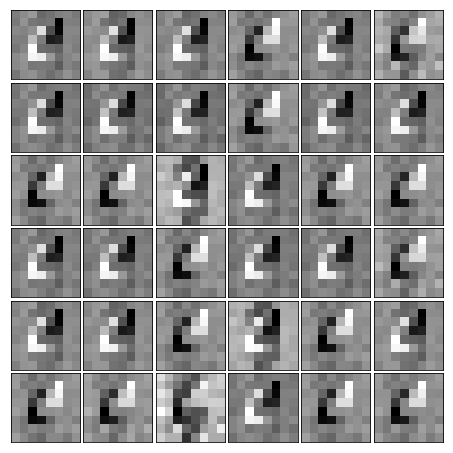

Computing: [######---------------------------------------] 14% 

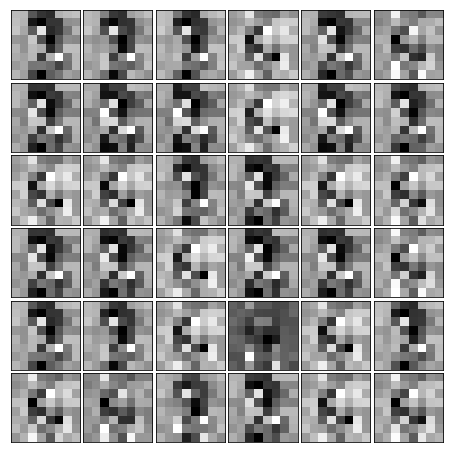

Computing: [##########-----------------------------------] 21% 

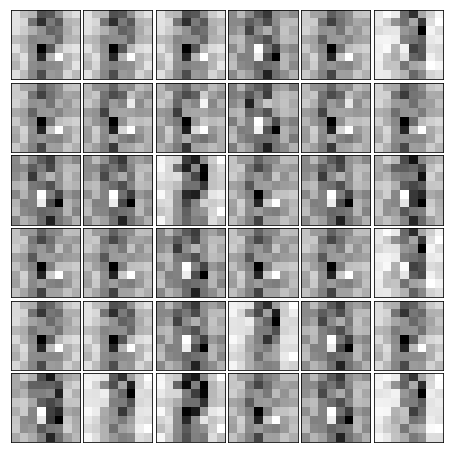

Computing: [#############--------------------------------] 29% 

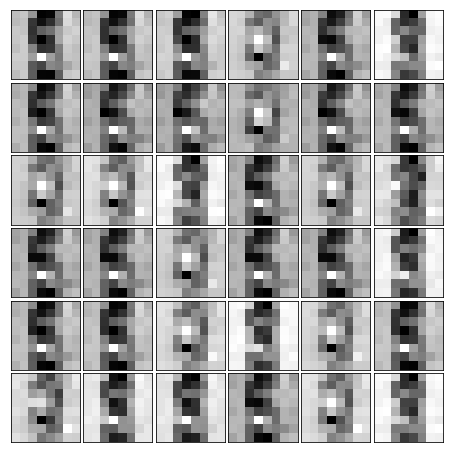

Computing: [################-----------------------------] 36% 

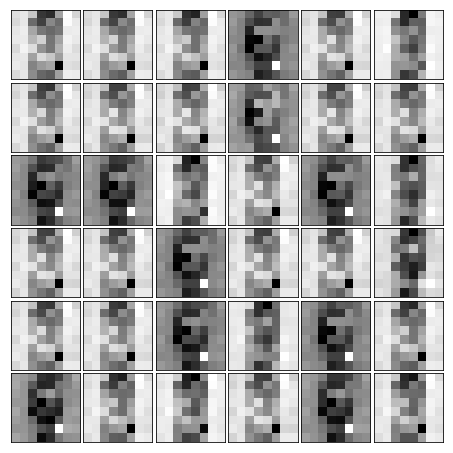

Computing: [###################--------------------------] 43% 

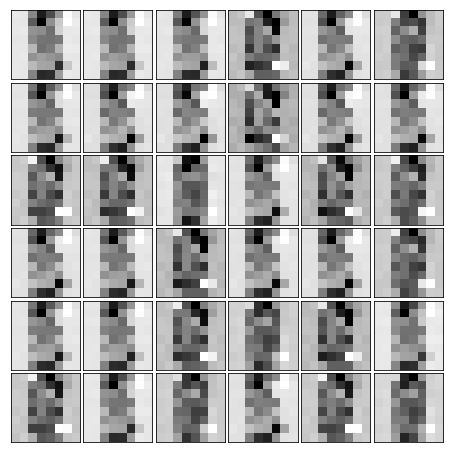

Computing: [######################-----------------------] 50% 

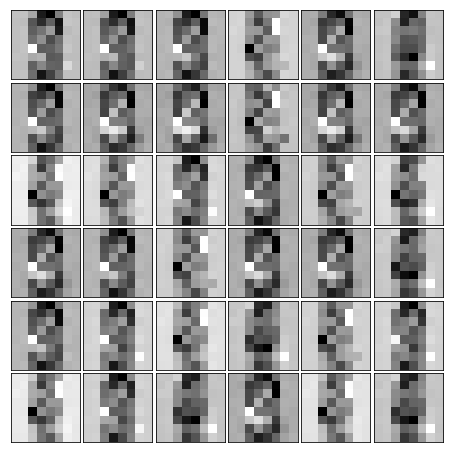

Computing: [##########################-------------------] 57% 

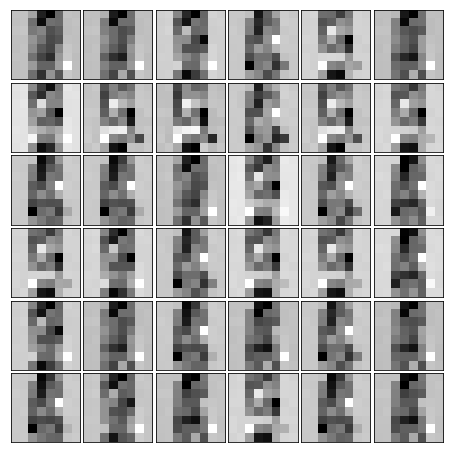

Computing: [#############################----------------] 64% 

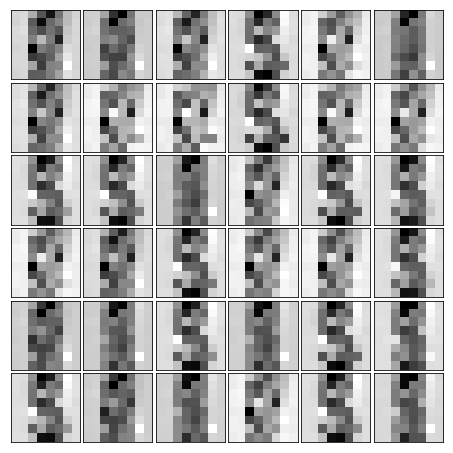

Computing: [################################-------------] 71% 

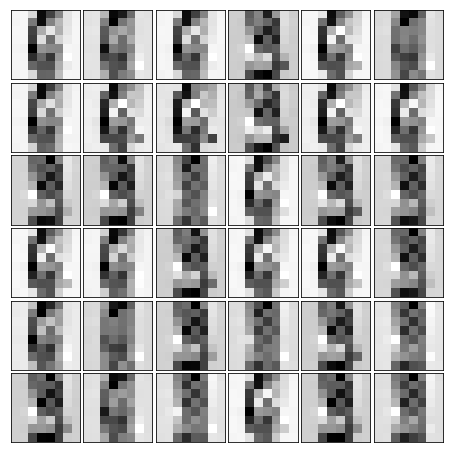

Computing: [###################################----------] 79% 

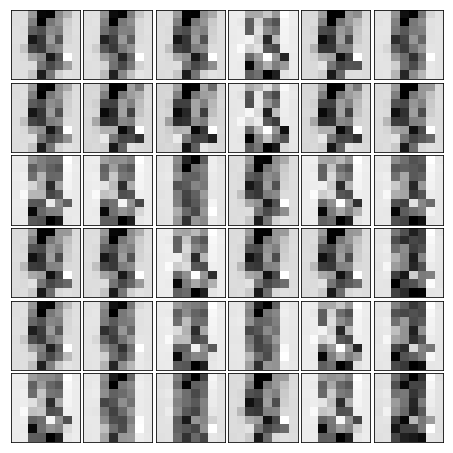

Computing: [#######################################------] 86% 

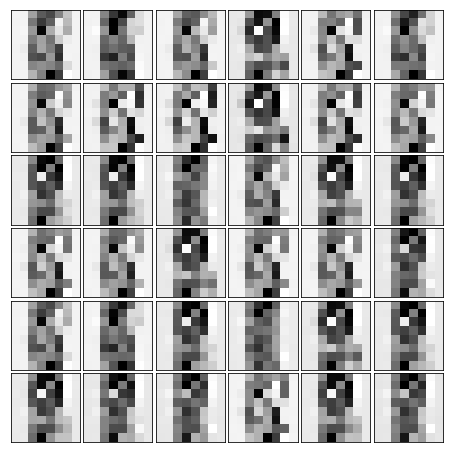

Computing: [##########################################---] 93% 

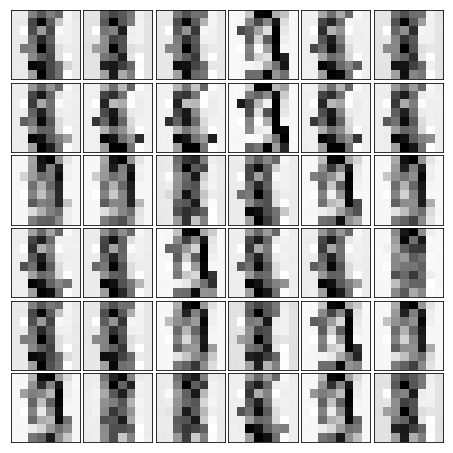

Computing: [#############################################] 100% 


In [7]:
for epoch_idx in range(model_epochs):

    # set the epoch id for print out
    print_epoch = epoch_idx + 1

    # set the discriminator to trainable
    discriminator.trainable = True

    for epoch_k in range(10):

        # draw random samples from real images
        index = np.random.choice(images.shape[0], half_batch, replace = False)

        imgs = images[index]

        d_noise = np.random.normal(0, 1, (half_batch, latent_dim))

        # generate a batch of new images
        gen_imgs = generator.predict(d_noise)

        # valid = [1, 0], fake = [0, 1]
        d_valid = np.concatenate((np.ones((half_batch, 1)), np.zeros((half_batch, 1))), axis = 1)
        d_fake  = np.concatenate((np.zeros((half_batch, 1)), np.ones((half_batch, 1))), axis = 1)

        # discriminator training
        d_loss_real, d_acc_real = discriminator.train_on_batch(imgs, d_valid)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(gen_imgs, d_fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_acc  = 0.5 * np.add(d_acc_real, d_acc_fake)

        if verbose:
            print('Epoch {} K:{} Discriminator Loss: {:2.4f}, Acc: {:2.4f}.'.format(print_epoch, epoch_k+1, d_loss, d_acc))

    # end of for epoch_k in range(10):

    model_stats['d_train_loss'].append(d_loss)
    model_stats['d_train_acc'].append(d_acc)

    # set the discriminator to not trainable
    discriminator.trainable = False

    # discriminator training
    g_noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # g_valid = [1, 0]
    g_valid = np.concatenate((np.ones((batch_size, 1)), np.zeros((batch_size, 1))), axis = 1)

    # train the generator
    g_loss, g_acc = generator_discriminator.train_on_batch(g_noise, g_valid)

    model_stats['g_train_loss'].append(g_loss)
    model_stats['g_train_acc'].append(g_acc)

    if epoch_idx % gen_epoch == 0 and epoch_idx > 0:
        plot_generated_img_samples(None,
                                          generator.predict(gen_noise).reshape((-1, img_rows, img_cols)),
                                          to_save    = False,
                                          iteration  = epoch_idx,
                                          model_name = model_name)

    if verbose:
        print('{}Epoch {} Discriminator Loss: {:2.4f}, Acc: {:2.4f}.'.format(print_pad(1), print_epoch, d_loss, d_acc))
        print('Epoch {} Generator Loss: {:2.4f}, Acc: {:2.4f}.{}'.format(print_epoch, g_loss, g_acc, print_pad(1)))
    else:
        computebar(model_epochs, epoch_idx)

### Plot the Model Loss and Accuracy Charts

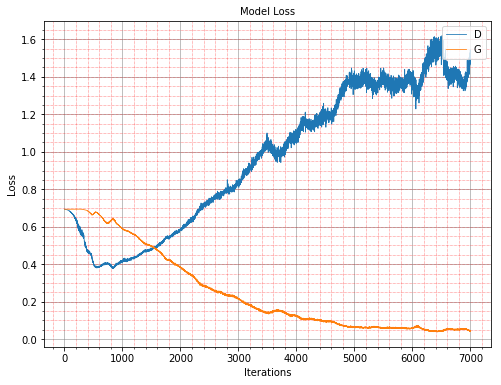

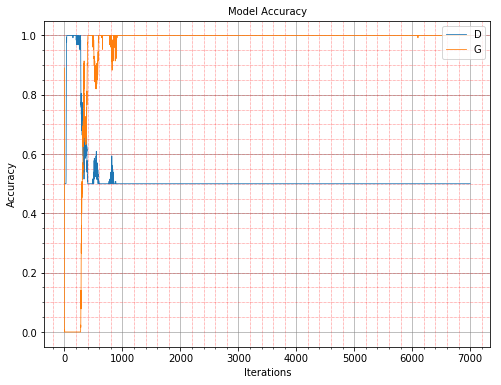

In [8]:
plot_metric('loss', model_epochs, model_stats['d_train_loss'], model_stats['g_train_loss'], legend = ['D', 'G'], model_name = model_name)
plot_metric('accuracy', model_epochs, model_stats['d_train_acc'], model_stats['g_train_acc'], legend = ['D', 'G'], model_name = model_name)

### Generate Sample Images

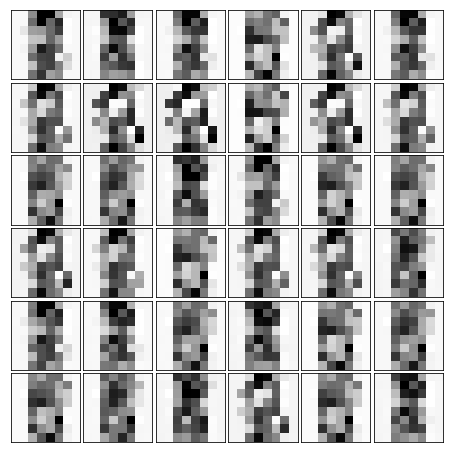

In [13]:
plot_generated_img_samples(None,
                                  generator.predict(gen_noise).reshape((-1, img_rows, img_cols)),
                                  to_save    = False,
                                  iteration  = model_epochs,
                                  model_name = model_name)